In [1]:
import torch
import torch.nn as nn
from DIP_blocks import *
import os
import random
import torch
import pytorch_lightning as pl
import numpy as np
import os
import logging
from functools import partial
import sys
sys.path.append("/home/xzhang/Documents/simplified_pipeline/")
from model.modules import *
from ray import tune
from config.config_Full_DIP_noise import *
from config.config_swin_unetr import *

import itertools
from collections.abc import Sequence
# from SwinTransformer import window_partition,window_reverse,WindowAttention,SwinTransformerBlock,PatchMerging,BasicLayer,SwinTransformer
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from torch.nn import LayerNorm

from typing import Sequence

In [2]:
import matplotlib.pyplot as plt

In [3]:
from model.swinUNET.SwinUNet import *
from model.swinUNET.SwinTransformer import *

from monai.networks.blocks import MLPBlock as Mlp



In [4]:
img_size = (128,128)
in_channels =1
out_channels = 1
depths = [2,2,2,2]
num_heads = (3,6,12,24)
feature_size = 48
norm_name = 'instance'
drop_rate = 0.
attn_drop_rate = 0.
dropout_path_rate = 0. 
normalize = False
use_checkpoint = False
spatial_dims = 2
downsample = 'merging'
use_v2 = False
window_size = (7,7)
patch_size = (2,2)
swinViT = SwinTransformer(
    in_chans=in_channels,
    embed_dim=feature_size,
    window_size=window_size,
    patch_size=patch_size,
    depths=depths,
    num_heads=num_heads,
    mlp_ratio=4.0,                       
    qkv_bias=True,
    drop_rate=drop_rate,
    attn_drop_rate=attn_drop_rate,
    drop_path_rate=dropout_path_rate,
    norm_layer=nn.LayerNorm,
    use_checkpoint=use_checkpoint,
    spatial_dims=spatial_dims,
    downsample=look_up_option(downsample, MERGING_MODE) if isinstance(downsample, str) else downsample,
    use_v2=use_v2,
)
#Unetrbasicblock 就是 两种模式选择 ： resblock （带残差链接的两个卷积层）或者 unetblock 两个直接卷积层 即 Unetresblock UnetBasicblock
#Unetrupblock 就是 先使用反卷积transposeblock, 然后和skip拼接之后再使用unetrbasic
encoder1 = UnetrBasicBlock(
    spatial_dims=spatial_dims,
    in_channels=in_channels,
    out_channels=feature_size,
    kernel_size=3,
    stride=1,
    norm_name=norm_name,
    res_block=True,
)

encoder2 = UnetrBasicBlock(
    spatial_dims=spatial_dims,
    in_channels=feature_size,
    out_channels=feature_size,
    kernel_size=3,
    stride=1,
    norm_name=norm_name,
    res_block=True,
)

encoder3 = UnetrBasicBlock(
    spatial_dims=spatial_dims,
    in_channels=2 * feature_size,
    out_channels=2 * feature_size,
    kernel_size=3,
    stride=1,
    norm_name=norm_name,
    res_block=True,
)

encoder4 = UnetrBasicBlock(
    spatial_dims=spatial_dims,
    in_channels=4 * feature_size,
    out_channels=4 * feature_size,
    kernel_size=3,
    stride=1,
    norm_name=norm_name,
    res_block=True,
)

encoder10 = UnetrBasicBlock(
    spatial_dims=spatial_dims,
    in_channels=16 * feature_size,
    out_channels=16 * feature_size,
    kernel_size=3,
    stride=1,
    norm_name=norm_name,
    res_block=True,
)

decoder5 = UnetrUpBlock(
    spatial_dims=spatial_dims,
    in_channels=16 * feature_size,
    out_channels=8 * feature_size,
    kernel_size=3,
    upsample_kernel_size=2,
    norm_name=norm_name,
    res_block=True,
)

decoder4 = UnetrUpBlock(
    spatial_dims=spatial_dims,
    in_channels=feature_size * 8,
    out_channels=feature_size * 4,
    kernel_size=3,
    upsample_kernel_size=2,
    norm_name=norm_name,
    res_block=True,
)

decoder3 = UnetrUpBlock(
    spatial_dims=spatial_dims,
    in_channels=feature_size * 4,
    out_channels=feature_size * 2,
    kernel_size=3,
    upsample_kernel_size=2,
    norm_name=norm_name,
    res_block=True,
)
decoder2 = UnetrUpBlock(
    spatial_dims=spatial_dims,
    in_channels=feature_size * 2,
    out_channels=feature_size,
    kernel_size=3,
    upsample_kernel_size=2,
    norm_name=norm_name,
    res_block=True,
)

decoder1 = UnetrUpBlock(
    spatial_dims=spatial_dims,
    in_channels=feature_size,
    out_channels=feature_size,
    kernel_size=3,
    upsample_kernel_size=2,
    norm_name=norm_name,
    res_block=True,
)

out_layer = UnetOutBlock(spatial_dims=spatial_dims, in_channels=feature_size, out_channels=out_channels)


NameError: name 'look_up_option' is not defined

In [5]:
# # x_in = torch.randn((1,1,128,128))
# # print(x_in.shape)
x_in = torch.from_numpy(np.load("/home/xzhang/Documents/我的模型/data/ground_truth/ground_truth_mr.npy")).view(1,1,128,128).float()

# print(x_in.shape,'x_in.shape')
# hidden_states_out = swinViT(x_in, normalize)
# for i in hidden_states_out:
#     print(i.shape)
# enc0 = encoder1(x_in)
# print(enc0.shape,'enc0')
# enc1 = encoder2(hidden_states_out[0])
# print(enc1.shape,'enc1')
# enc2 = encoder3(hidden_states_out[1])
# print(enc2.shape,'enc2')
# enc3 = encoder4(hidden_states_out[2])
# print(enc3.shape,'enc3')
# dec4 = encoder10(hidden_states_out[4])
# print(dec4.shape,'dec4')
# dec3 = decoder5(dec4, hidden_states_out[3])
# print(dec3.shape,'dec3')
# dec2 = decoder4(dec3, enc3)
# print(dec2.shape,'dec2')
# dec1 = decoder3(dec2, enc2)
# print(dec1.shape,'dec1')
# dec0 = decoder2(dec1, enc1)
# out = decoder1(dec0, enc0)
# print(dec0.shape,'dec0')
# print(out.shape,'out')
# logits = out_layer(out)
# print(logits.shape,'logits')
x_plot = np.squeeze(x_in.detach().numpy())
# logits_plot = np.squeeze(logits.detach().numpy())
x_plot_norm = (x_plot - x_plot.min()) / (x_plot.max() - x_plot.min())
# logits_plot_norm = (logits_plot - logits_plot.min()) / (logits_plot.max() - logits_plot.min())

# plt.subplot(1, 2, 1)  # Create the first subplot
# plt.imshow(x_plot_norm, cmap='gray_r')
# plt.title('x_plot')

# plt.subplot(1, 2, 2)  # Create the second subplot
# plt.imshow(logits_plot_norm, cmap='gray_r')
# plt.title('logits_plot')

# # Create a colorbar
# cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
# plt.colorbar(cax=cax)

# plt.show()

# print(np.max(logits_plot),np.min(logits_plot))
# print(np.max(x_plot),np.min(x_plot))

(128, 128, 1)
0.0


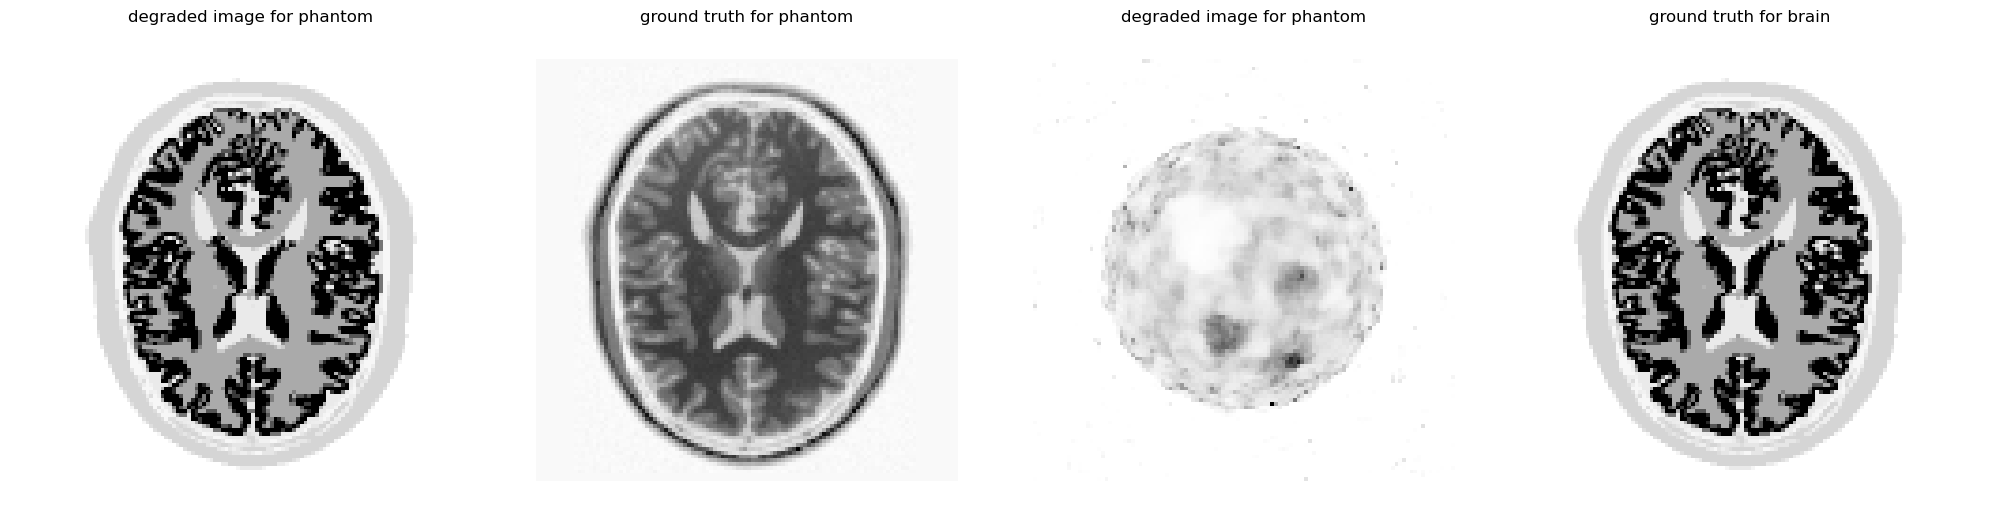

2894.25 0.0
2894.25 0.0


In [11]:
# Swin_UNet,SwinIR,Swin_UNetr,Unet
# Ground Truth 

y_plot = np.load("/home/xzhang/Documents/我的模型/data/ground_truth/ground_truth_brain.npy")
y0_plot = np.load("/home/xzhang/Documents/simplified_pipeline/data/results/images/Swin_Unet_brain/swin_unet/48_4_6_0/average.npy")
y1_plot = np.load("/home/xzhang/Documents/simplified_pipeline/data/results/images/swin_unetr_brain/Swin_Unetr_mr/48_2_3_0.1/average.npy")
y2_plot = np.load("/home/xzhang/Documents/simplified_pipeline/data/results/images/test_swin_unetr/non_res_act_concat_2_7/4_24_2_4/average.npy")
y3_plot = np.load("/home/xzhang/Documents/simplified_pipeline/data/results/images/skip_brain/DIP_skip_add_mr/3_128_0/average.npy")
fig, axs = plt.subplots(1, 5, figsize=(20, 10))
print(np.min(y_plot))
# First subplot
axs[0].imshow(y_plot, cmap='gray_r')
axs[0].set_title('ground truth brain')
axs[0].axis('off')

# Second subplot
axs[1].imshow(y0_plot, cmap='gray_r')
axs[1].set_title('Swin unet average')
axs[1].axis('off')

# Second subplot
axs[2].imshow(y1_plot, cmap='gray_r')
axs[2].set_title('Swin IR average')
axs[2].axis('off')

# Third subplot
axs[3].imshow(y2_plot, cmap='gray_r')
axs[3].set_title('Swin Unetr average')
axs[3].axis('off')

axs[4].imshow(y3_plot, cmap='gray_r')
axs[4].set_title('DIP average')
axs[4].axis('off')

plt.tight_layout()
plt.show()

print(np.max(y_plot),np.min(y_plot))
print(np.max(x_plot),np.min(x_plot))

In [ ]:
bias = average - gt 

NameError: name 'average' is not defined

In [ ]:
import numpy as np
y1_plot = np.load("/home/xzhang/Documents/我的模型/data/corrupted_images/target_padded_brain.npy")
y1_plot = y1_plot[8:-8,8:-8,:]
print(y1_plot.shape)
# y2_plot=np.zeros((128,128,1))
# y2_plot[1:-1,1:-1,:]=y1_plot
# print(y2_plot.shape)

(112, 112, 1)


In [ ]:
np.save("/home/xzhang/Documents/我的模型/data/corrupted_images/target_padded_sunet_brain.npy",y1_plot)

In [ ]:
import torch 
import einops

In [ ]:
x = torch.randn((1,16,2,2))
x

tensor([[[[ 0.1405,  0.6733],
          [ 1.2915,  0.6975]],

         [[ 1.6788, -0.9059],
          [ 0.0054,  1.5909]],

         [[ 1.4579, -0.7525],
          [ 1.0221, -0.0814]],

         [[-0.9173,  0.9485],
          [ 0.2966, -0.7503]],

         [[ 0.1703, -0.0130],
          [ 0.6831,  0.5742]],

         [[ 0.0646,  1.9760],
          [ 1.5188,  0.8541]],

         [[-0.0796, -0.3807],
          [ 1.5061,  0.7134]],

         [[-0.8968,  1.6071],
          [-0.5574,  1.6393]],

         [[ 0.2868, -0.8730],
          [-0.2671,  1.6722]],

         [[-0.3049, -0.3832],
          [-0.8736, -0.5387]],

         [[-0.1646,  0.7281],
          [ 0.5676,  0.0595]],

         [[-1.1127,  0.5800],
          [-0.7363, -1.2583]],

         [[ 1.3767,  2.7486],
          [-0.4504,  1.3650]],

         [[ 0.8204, -1.6074],
          [-0.2907, -1.5825]],

         [[ 1.3473, -0.3680],
          [-1.0159, -0.3702]],

         [[ 0.7080, -0.1959],
          [ 1.2537,  0.5606]]]])

In [ ]:

x = rearrange(x, 'b (p1 p2 c) h w -> b c (h p1) (w p2)', p1=4, p2=4, c=16//(4**2))
x


tensor([[[[ 0.1405,  1.6788,  1.4579, -0.9173,  0.6733, -0.9059, -0.7525,
            0.9485],
          [ 0.1703,  0.0646, -0.0796, -0.8968, -0.0130,  1.9760, -0.3807,
            1.6071],
          [ 0.2868, -0.3049, -0.1646, -1.1127, -0.8730, -0.3832,  0.7281,
            0.5800],
          [ 1.3767,  0.8204,  1.3473,  0.7080,  2.7486, -1.6074, -0.3680,
           -0.1959],
          [ 1.2915,  0.0054,  1.0221,  0.2966,  0.6975,  1.5909, -0.0814,
           -0.7503],
          [ 0.6831,  1.5188,  1.5061, -0.5574,  0.5742,  0.8541,  0.7134,
            1.6393],
          [-0.2671, -0.8736,  0.5676, -0.7363,  1.6722, -0.5387,  0.0595,
           -1.2583],
          [-0.4504, -0.2907, -1.0159,  1.2537,  1.3650, -1.5825, -0.3702,
            0.5606]]]])

In [ ]:


fig, axs = plt.subplots(5, len(data), figsize=(3* len(data), 20))
fig.subplots_adjust(hspace=0.1)

# 根据上面获得的最佳和最差图片，找到并且打印出来
# 遍历每一行
for i, row in data.iterrows(): 
    # 构造文件路径
    best_image_path = path_suffix + f"{row['model']}/{row['embed_dims']}_{row['depths']}_{row['num_heads']}_{row['sigma_p']}/{row['best_result_train']}/iters_{row['b_iteration']}.npy"
    average_path = path_suffix + f"{row['model']}/{row['embed_dims']}_{row['depths']}_{row['num_heads']}_{row['sigma_p']}/average.npy"
    worst_image_path = path_suffix + f"{row['model']}/{row['embed_dims']}_{row['depths']}_{row['num_heads']}_{row['sigma_p']}/{row['worst_result_train']}/iters_{row['w_iteration']}.npy"
    bias_path = path_suffix + f"{row['model']}/{row['embed_dims']}_{row['depths']}_{row['num_heads']}_{row['sigma_p']}/bias.npy"
    variance_path = path_suffix + f"{row['model']}/{row['embed_dims']}_{row['depths']}_{row['num_heads']}_{row['sigma_p']}/variance.npy"
    
    best_image = np.load(best_image_path)
    average_image = np.load(average_path)
    worst_image = np.load(worst_image_path)
    bias_image = np.load(bias_path)
    variance_image = np.load(variance_path)

    axs[0, i].imshow(best_image, cmap='gray_r')
    axs[0, i].set_title(f"Best result {row['model']}")
    axs[0, i].axis('off')
    axs[0, i].set_aspect('equal')  # 设置图像比例为1:1
    
    axs[1, i].imshow(average_image, cmap='gray_r')
    axs[1, i].set_title(f"Average result {row['model']}")
    axs[1, i].axis('off')
    axs[1, i].set_aspect('equal')  # 设置图像比例为1:1
        
    axs[2, i].imshow(worst_image, cmap='gray_r')
    axs[2, i].set_title(f"Worst result {row['model']}")
    axs[2, i].axis('off')
    axs[2, i].set_aspect('equal')  # 设置图像比例为1:1
    
    axs[3, i].imshow(bias_image, cmap='gray_r')
    axs[3, i].set_title(f"Bias {row['model']}")
    axs[3, i].axis('off')
    axs[3, i].set_aspect('equal')  # 设置图像比例为1:1
    
    axs[4, i].imshow(variance_image, cmap='gray_r')
    axs[4, i].set_title(f"Variance {row['model']}")
    axs[4, i].axis('off')
    axs[4, i].set_aspect('equal')  # 设置图像比例为1:1
  # 设置colorbar的位置和尺寸
    cax = fig.add_axes([1.0, 0.5, 0.02, 0.3])  # 设置colorbar的位置和尺寸
    fig.colorbar(axs[0, 0].images[0], cax=cax)   # 给best_image添加colorbar
    cax = fig.add_axes([1.0, 0.25, 0.02, 0.1])  # 设置colorbar的位置和尺寸
    fig.colorbar(axs[3, 0].images[0], cax=cax)
    cax = fig.add_axes([1.0, 0.08, 0.02, 0.1])  # 设置colorbar的位置和尺寸
    fig.colorbar(axs[3, 0].images[0], cax=cax)      
    
# 调整整个图像的布局和尺寸
plt.tight_layout()
plt.show();

In [ ]:
import torch
import torch.nn as nn
from DIP_blocks import *
input  = torch.randn((1,1,128,128))
conv =  UnetSkipAdd(1,4,1,
                                       kernel_size=3,
                                       skip=3,
                                       num_layer=3,
                                       depths=16,
                                       mode='bilinear')
output = conv(input)
print(output.shape)

torch.Size([1, 4, 128, 128])
torch.Size([1, 8, 64, 64])
torch.Size([1, 16, 32, 32])
encoder_final torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 16, 32, 32])
0 torch.Size([1, 16, 32, 32]) torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 8, 64, 64])
1 torch.Size([1, 8, 64, 64]) torch.Size([1, 8, 64, 64])
torch.Size([1, 8, 64, 64])
torch.Size([1, 4, 128, 128])
2 torch.Size([1, 4, 128, 128]) torch.Size([1, 4, 128, 128])
torch.Size([1, 1, 128, 128])
